Unsupported Ngspice version 45


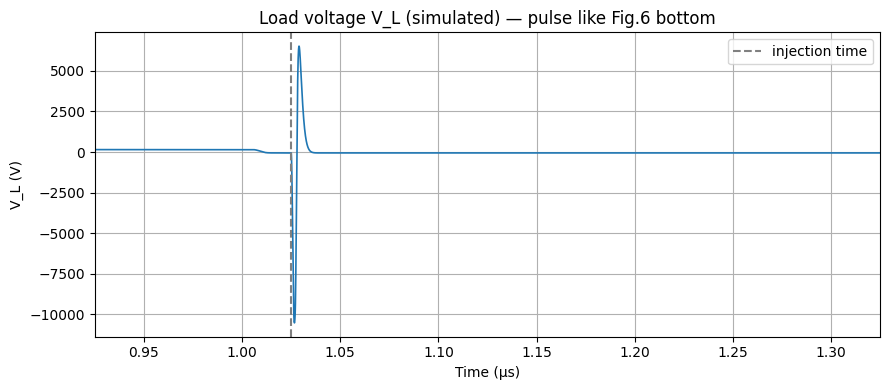

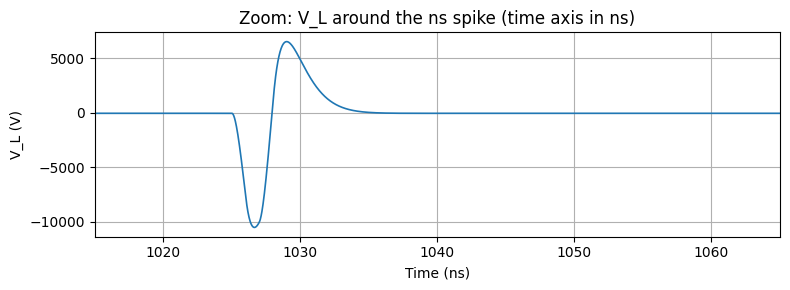

Done — VL data saved to VL_pulse_fig6_data.txt


In [1]:
# vl_pulse_fig6.py
# Produces the VL waveform (sharp nanosecond pulse) like Fig.6 bottom.
# Uses a bipolar Vin and injects a short reverse current (Iinj) at the polarity flip to emulate diode snap-off.
# Requirements: PySpice + ngspice installed.

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# Parameters (tuneable)
# -----------------------
# Input bipolar timing (match Fig.6)
A1 = 55.0            # magnitude of negative half (V)
A2 = 150.0           # magnitude of positive half (V)
T1 = 1.0e-6          # negative half duration (s)
T2 = 0.5e-6          # positive half duration (s)
TR = 5e-9            # rise/fall time (s)
PER = T1 + T2 + 0.5e-6

# Circuit
L_val = 0.1e-6       # H (0.1 µH)
Ceff  = 10e-12       # F (effective capacitance, tune to adjust pulse width)
RL    = 50.0         # Ohm (load)
Rs    = 0.1          # small series resistance

# Injected reverse current parameters (emulates IRM)
# Place injection slightly after the polarity flip (simulate storage delay)
tsd_est = 25e-9      # estimated storage delay after polarity flip (s) -> tune
t_inject = T1 + tsd_est   # inject time ~ end of negative half + storage delay
Ipeak = 300.0        # A (peak of injected reverse current) — tune to set VL amplitude
inj_width = 1.0e-9   # s (very short current pulse to get ns spike)

# Simulation settings
sim_end = T1 + T2 + 0.5e-6
step_time = 0.02e-9  # fine time resolution to capture ns pulse

# -----------------------
# Build circuit
# -----------------------
circuit = Circuit('VL_pulse_fig6')

# Bipolar input source (Vin)
circuit.V('in', 'vin', circuit.gnd, f'PULSE({-A1} {A2} 0 {TR} {TR} {T1} {PER})')

# Inductor between vin and node 'n'
circuit.L('1', 'vin', 'n', L_val)
# small parasitic to ground
circuit.C('par', 'n', circuit.gnd, 1e-12)

# series parasitic and load
circuit.R('rs', 'n', 'n_r', Rs)
circuit.R('rl', 'n_r', circuit.gnd, RL)

# effective capacitance at load node (Ceff ~ Cj1 + Cgdt + Cind)
circuit.C('ceff', 'n_r', circuit.gnd, Ceff)

# Injected current to emulate IRM (a short pulse)
# PULSE(Ioff Ion Delay Tr Tf PW Period)
Iexpr = f'PULSE(0 {Ipeak} {t_inject} 1n 1n {inj_width} {sim_end})'
circuit.I('inj', 'n_r', circuit.gnd, Iexpr)

# -----------------------
# Simulate
# -----------------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=step_time, end_time=sim_end)

# -----------------------
# Extract & plot VL
# -----------------------
time = np.array(analysis.time)
v_load = np.array(analysis.nodes['n_r'])

# Plot full timeframe with indication of injection time
plt.figure(figsize=(9,4))
plt.plot(time * 1e6, v_load, linewidth=1.2)
plt.axvline(x=t_inject * 1e6, color='gray', linestyle='--', label='injection time')
plt.title('Load voltage V_L (simulated) — pulse like Fig.6 bottom')
plt.xlabel('Time (µs)')
plt.ylabel('V_L (V)')
plt.grid(True)

# zoom region around the pulse for clear view
zoom_center = t_inject
zoom_span = 0.4e-6   # show ~0.4 µs window (adjust)
plt.xlim((zoom_center - 0.1e-6) * 1e6, (zoom_center + 0.3e-6) * 1e6)

plt.legend()
plt.tight_layout()
plt.show()

# Also zoom very tightly to show nanosecond spike shape
plt.figure(figsize=(8,3))
plt.plot(time * 1e9, v_load, linewidth=1.2)
plt.title('Zoom: V_L around the ns spike (time axis in ns)')
plt.xlabel('Time (ns)')
plt.ylabel('V_L (V)')
plt.grid(True)
# set tight x-limits around the spike
plt.xlim((t_inject - 10e-9) * 1e9, (t_inject + 40e-9) * 1e9)
plt.tight_layout()
plt.show()

# Save data
np.savetxt('VL_pulse_fig6_data.txt', np.column_stack((time, v_load)), header='time(s) Vload(V)')
print('Done — VL data saved to VL_pulse_fig6_data.txt')

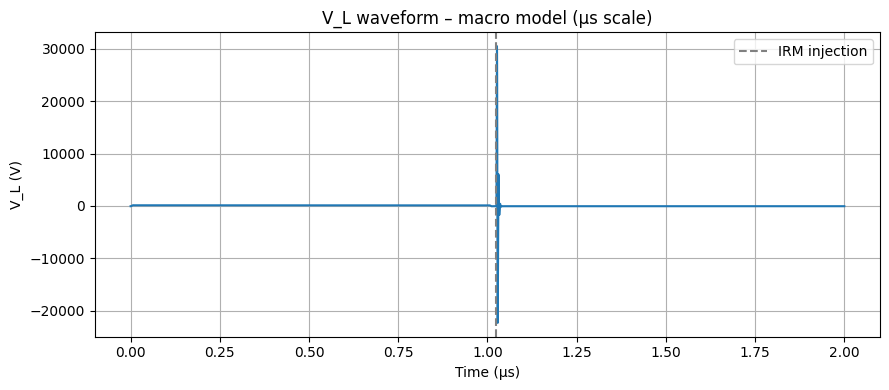

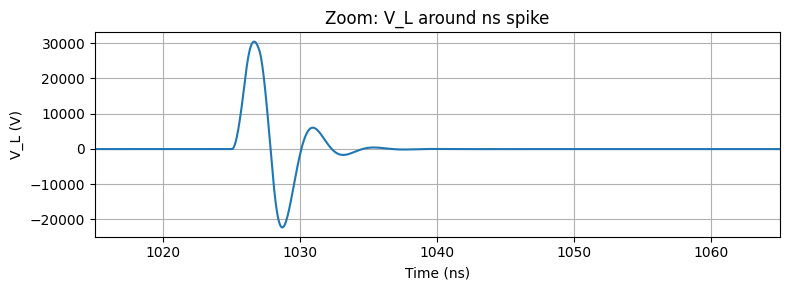

Done — VL data saved to VL_pulse_fig6_data.txt


In [5]:
# vl_pulse_fig6_clean_corrected2.py
# Macro model: L feeding a single node with RL || Ceff,
# plus a short injected reverse current emulating IRM.
# Tuned so V_L is a single positive spike (like Fig. 6 bottom).

from PySpice.Spice.Netlist import Circuit
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# Parameters (tuneable)
# -----------------------
A1 = 55.0            # negative half (V)
A2 = 150.0           # positive half (V)
T1 = 1.0e-6          # duration of negative half (s)
T2 = 0.5e-6          # duration of positive half (s)
TR = 5e-9            # rise/fall time (s)
PER = T1 + T2 + 0.5e-6

L_val = 0.1e-6       # H

# >>> tuned for single positive spike
Ceff  = 5e-12        # F  (smaller C -> narrower pulse)
RL    = 300.0        # Ohm (higher R -> more damping)
Rs    = 50.0         # Ohm (series damping with L)

tsd_est  = 25e-9     # storage delay after polarity flip (s)
t_flip   = T1        # when Vin changes sign
t_inject = t_flip + tsd_est

Ipeak    = 300.0     # A magnitude (sets VL amplitude)
inj_width = 1.0e-9   # s  (short reverse current pulse)

sim_end   = PER      # simulate one full period
step_time = 0.05e-9  # 50 ps

# -----------------------
# Build circuit
# -----------------------
circuit = Circuit('VL_pulse_fig6_clean')

# Bipolar input source Vin
circuit.V('in', 'vin', circuit.gnd,
          f'PULSE({-A1} {A2} 0 {TR} {TR} {T1} {PER})')

# Series L (+ Rs) to node nx
circuit.L('L1', 'vin', 'nL', L_val)
circuit.R('RS', 'nL', 'nx', Rs)

# RL || Ceff at node nx (this node voltage is V_L)
circuit.R('RL', 'nx', circuit.gnd, RL)
circuit.C('CEFF', 'nx', circuit.gnd, Ceff)

# Injected reverse current at node nx emulating IRM
# NOTE: 0 -> -Ipeak so the main VL lobe is positive.
Iexpr = f'PULSE(0 {-Ipeak} {t_inject} 1n 1n {inj_width} {sim_end})'
circuit.I('inj', 'nx', circuit.gnd, Iexpr)

# -----------------------
# Simulate
# -----------------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=step_time, end_time=sim_end)

time = np.array(analysis.time)
vL = np.array(analysis.nodes['nx'])   # VL = voltage at node nx

# -----------------------
# Plots
# -----------------------
# µs-scale view
plt.figure(figsize=(9, 4))
plt.plot(time * 1e6, vL)
plt.axvline(t_inject * 1e6, color='gray', linestyle='--', label='IRM injection')
plt.title('V_L waveform – macro model (µs scale)')
plt.xlabel('Time (µs)')
plt.ylabel('V_L (V)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ns-scale zoom around spike
plt.figure(figsize=(8, 3))
plt.plot(time * 1e9, vL)
plt.title('Zoom: V_L around ns spike')
plt.xlabel('Time (ns)')
plt.ylabel('V_L (V)')
plt.grid(True)
plt.xlim((t_inject - 10e-9) * 1e9, (t_inject + 40e-9) * 1e9)
plt.tight_layout()
plt.show()

# Optional: save data
np.savetxt('VL_pulse_fig6_data.txt',
           np.column_stack((time, vL)),
           header='time(s) Vload(V)')
print('Done — VL data saved to VL_pulse_fig6_data.txt')


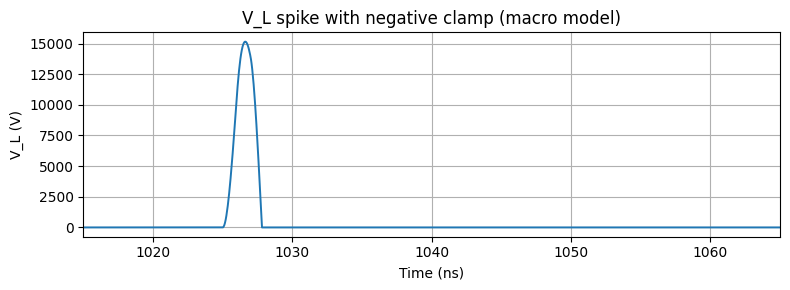

In [7]:
# vl_pulse_fig6_clamped_fixed.py
# Macro model with negative clamp diode so V_L is a single positive spike.

from PySpice.Spice.Netlist import Circuit
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# Parameters
# -----------------------
A1 = 55.0
A2 = 150.0
T1 = 1.0e-6
T2 = 0.5e-6
TR = 5e-9
PER = T1 + T2 + 0.5e-6

L_val = 0.1e-6       # H
Ceff  = 5e-12        # F
RL    = 300.0        # ohm
Rs    = 50.0         # ohm

tsd_est  = 25e-9
t_flip   = T1
t_inject = t_flip + tsd_est

Ipeak    = 150.0     # A (reduced a bit so numbers aren't insane)
inj_width = 1.0e-9   # s

sim_end   = PER
step_time = 0.05e-9  # 50 ps

# -----------------------
# Build circuit
# -----------------------
circuit = Circuit('VL_pulse_fig6_clamped_fixed')

# Bipolar Vin (mainly so timing matches the paper)
circuit.V('in', 'vin', circuit.gnd,
          f'PULSE({-A1} {A2} 0 {TR} {TR} {T1} {PER})')

# L + Rs to node nx
circuit.L('L1', 'vin', 'nL', L_val)
circuit.R('RS', 'nL', 'nx', Rs)

# RL || Ceff at node nx  (V(nx) = V_L)
circuit.R('RL', 'nx', circuit.gnd, RL)
circuit.C('CEFF', 'nx', circuit.gnd, Ceff)

# Injected reverse current emulating IRM:
# *** current flows from GND -> nx (positive spike at nx) ***
Iexpr = f'PULSE(0 {Ipeak} {t_inject} 1n 1n {inj_width} {sim_end})'
circuit.I('inj', circuit.gnd, 'nx', Iexpr)

# -----------------------
# NEGATIVE CLAMP DIODE (correct orientation)
# Anode = GND, Cathode = nx
# When V(nx) < ~ -0.7 V, diode conducts and clamps the negative swing.
# -----------------------
circuit.model('Dclamp', 'D', Is=1e-15, N=1)
circuit.D('NCLAMP', circuit.gnd, 'nx', model='Dclamp')

# -----------------------
# Simulate
# -----------------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=step_time, end_time=sim_end)

time = np.array(analysis.time)
vL = np.array(analysis.nodes['nx'])

# -----------------------
# Plot: zoomed ns spike only (like Fig. 6)
# -----------------------
plt.figure(figsize=(8, 3))
plt.plot(time * 1e9, vL, linewidth=1.4)
plt.title('V_L spike with negative clamp (macro model)')
plt.xlabel('Time (ns)')
plt.ylabel('V_L (V)')
plt.grid(True)
plt.xlim((t_inject - 10e-9) * 1e9, (t_inject + 40e-9) * 1e9)
plt.tight_layout()
plt.show()
